# Store Item Demand Forecasting Challenge Data


In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sktime.split import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import ForecastingPipeline
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.series.summarize import WindowSummarizer
import lightgbm as lgb

from src.constants import RANDOM_STATE, LGBM_MODEL_PARAMS

In [2]:
np.random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Load data

In [3]:
data_raw = pd.read_csv("../data/train.csv")
data = data_raw.copy()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [20]:
data.sample(2)

,,,sales
store,item,date,
9,6,2014-01-02,24
1,7,2015-05-22,55


In [ ]:
data = data.set_index(["store", "item", "date"], drop=False)

In [ ]:
X = None
y = None

## Pre-processing

In [5]:
X_train, X_test, y_train, y_test = temporal_train_test_split(y, X, test_size=14)

In [ ]:
#TODO: encode categories

In [ ]:
#TODO: extract date features

In [7]:
train_data_normal = lgb.Dataset(X_train, label=y_train)
lgbm_normal = lgb.train(LGBM_MODEL_PARAMS, train_data_normal)
y_pred_lgbm_normal = lgbm_normal.predict(X_test, num_iteration=lgbm_normal.best_iteration)

C:\Users\Mateusz\miniconda3\envs\linear-trees\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [8]:
train_data_linear = lgb.Dataset(X_train, label=y_train, params={"linear_tree": True})
lgbm_linear = lgb.train(LGBM_MODEL_PARAMS, train_data_linear)
y_pred_lgbm_linear = lgbm_linear.predict(X_test, num_iteration=lgbm_linear.best_iteration)

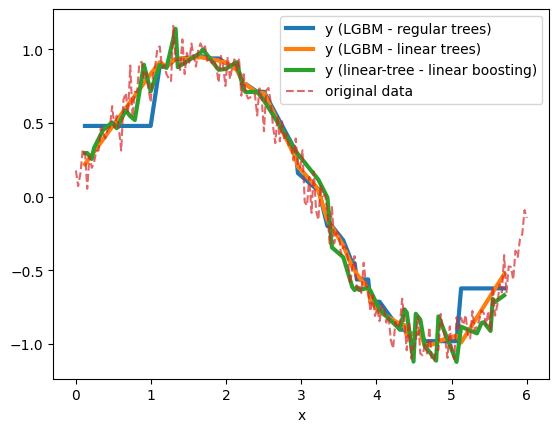

In [32]:
df = pd.DataFrame(X_test, columns=["x"])
df["y (LGBM - regular trees)"] = y_pred_lgbm_normal
df["y (LGBM - linear trees)"] = y_pred_lgbm_linear
df.sort_values("x").set_index("x").plot(lw=3)
plt.plot(X, y, label="original data", alpha=0.7, linestyle="--")
plt.legend()
plt.show()

## Error metrics

In [33]:
print(f"LGBM | Normal trees error: {round(mean_squared_error(y_test, y_pred_lgbm_normal),3)}")
print(f"LGBM | Linear trees error: {round(mean_squared_error(y_test, y_pred_lgbm_linear),3)}")

LGBM | Normal trees error: 0.026
LGBM | Linear trees error: 0.012
Linear-tree | Normal trees error: 0.026


## Extrapolation

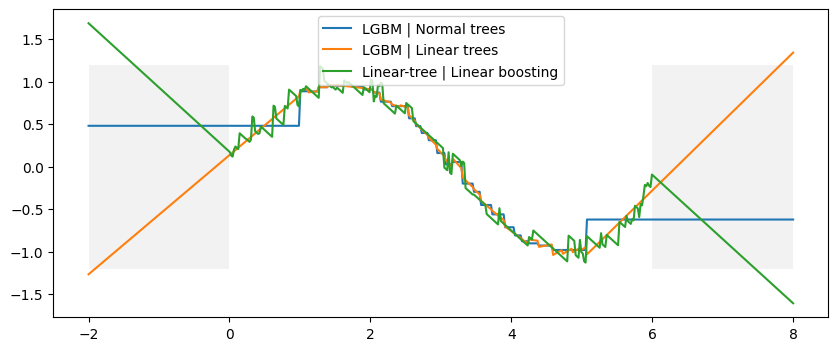

In [30]:
X_extrapol = np.linspace(-2, 8, 500)
X_extrapol = X_extrapol.reshape(X_extrapol.shape[0],1)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(X_extrapol, lgbm_normal.predict(X_extrapol, num_iteration=lgbm_normal.best_iteration), label="LGBM | Normal trees")
ax.plot(X_extrapol, lgbm_linear.predict(X_extrapol, num_iteration=lgbm_linear.best_iteration), label="LGBM | Linear trees")
ax.legend()

ax.fill_between(np.linspace(-2,0), -1.2, 1.2, facecolor="gray", alpha=0.1)
ax.fill_between(np.linspace(6,8), -1.2, 1.2, facecolor="gray", alpha=0.1)

plt.show()